# 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import gc;gc.collect
import datetime

from subprocess import check_output

# 데이터 로드

In [2]:
data_path = './data/'

In [3]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')
test = pd.read_csv(data_path + 'test.csv')
train_2016 = pd.read_csv(data_path + 'train_2016.csv')

date_list=np.unique(train_2016["date"])

# PreProcessing

### 메모리 소모 감소 ( 최적화 )

In [4]:
memo = train_2016.memory_usage(index=True).sum()
print(memo/ 1024**2," MB")


1075.1304626464844  MB


In [5]:
print(train_2016.dtypes)

date           object
store_nbr       int64
item_nbr        int64
unit_sales    float64
dtype: object


In [6]:
train_2016['store_nbr'] = train_2016['store_nbr'].astype(np.int8)
train_2016['item_nbr'] = train_2016['item_nbr'].astype(np.int32)
train_2016['unit_sales'] = train_2016['unit_sales'].astype(np.int8)

In [7]:
memo = train_2016.memory_usage(index=True).sum()
print(memo/ 1024**2," MB")


470.3696460723877  MB


In [8]:
train_2016

,date,store_nbr,item_nbr,unit_sales
0,2016-01-01,25,105574,12
1,2016-01-01,25,105575,9
2,2016-01-01,25,105857,3
3,2016-01-01,25,108634,3
4,2016-01-01,25,108701,2
...,...,...,...,...
35229866,2016-12-31,54,2048381,6
35229867,2016-12-31,54,2048421,4
35229868,2016-12-31,54,2048471,10
35229869,2016-12-31,54,2048515,3


### 특정 판매점, 특정 상품 1개씩 선택

In [29]:
train_2016_25= train_2016[train_2016["store_nbr"] == 25]
train_2016_25_105574= train_2016_25[train_2016_25["item_nbr"] == 105574]
train_2016_25_105574.drop("store_nbr",axis=1,inplace=True)
train_2016_25_105574.drop("item_nbr",axis=1,inplace=True)
train_2016_25_105574

d:\users\wjdgu\anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,unit_sales
0,2016-01-01,12
46607,2016-01-02,16
147190,2016-01-03,9
246245,2016-01-04,4
341760,2016-01-05,6
...,...,...
34738111,2016-12-27,8
34842774,2016-12-28,1
34949141,2016-12-29,16
35056945,2016-12-30,12


In [38]:
train_copy = train_2016_25_105574.copy()

train_copy.set_index('date')

,unit_sales
date,
2016-01-01,12
2016-01-02,16
2016-01-03,9
2016-01-04,4
2016-01-05,6
...,...
2016-12-27,8
2016-12-28,1
2016-12-29,16


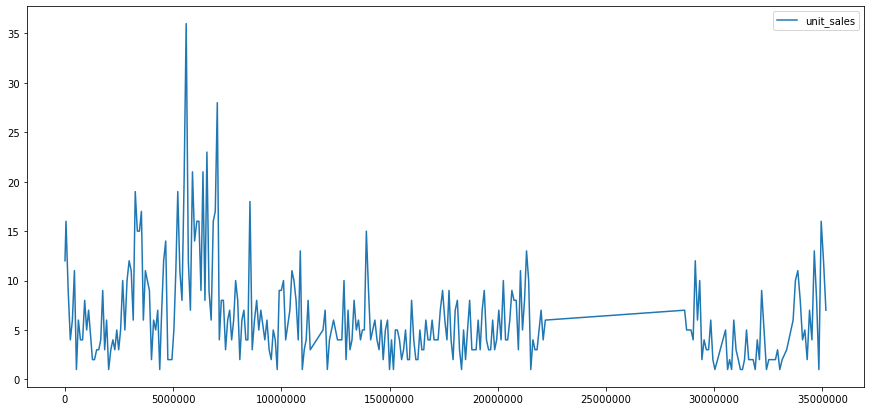

In [39]:
train_copy.plot(figsize=(15, 7))
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.show()

In [47]:
df_date=pd.DataFrame(date_list)
df_date = df_date.rename(columns={0: 'date'})
df_date.head()

,date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [67]:
df = pd.merge(df_date, train_2016_25_105574, how='left', on=['date'])
df.fillna(0,inplace=True)

df.tail()

,date,unit_sales
360,2016-12-27,8.0
361,2016-12-28,1.0
362,2016-12-29,16.0
363,2016-12-30,12.0
364,2016-12-31,7.0


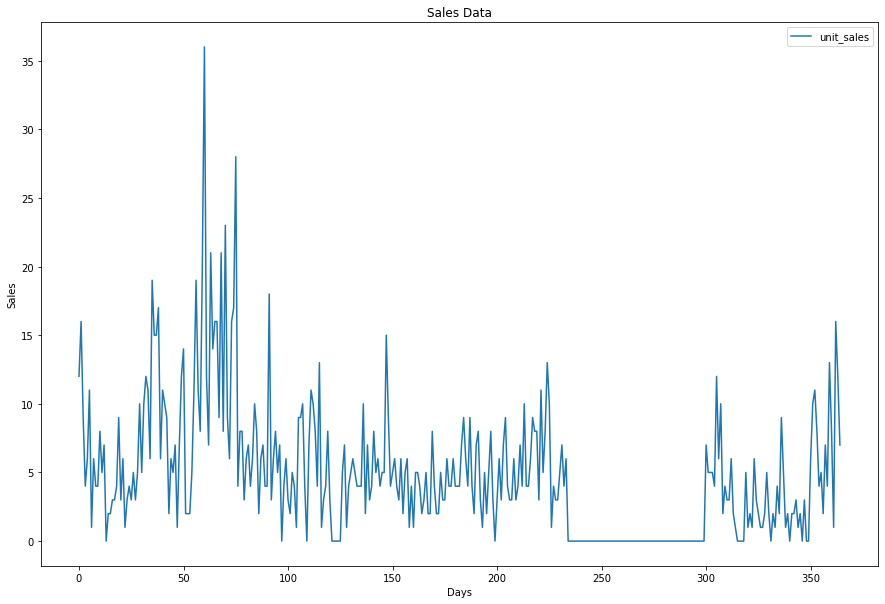

In [68]:
df.plot(figsize=(15, 10))

plt.title('Sales Data')
plt.xlabel('Days')
plt.ylabel('Sales')

plt.show()
df.describe()

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# 학습, 테스트 셋 준비

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [51]:
# fix random seed for reproducibility
np.random.seed(7)

In [58]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
train, test =df[df["date"].dt.month <= 9], df[df["date"].dt.month > 9]

In [59]:
train

,date,unit_sales
0,2016-01-01,12.0
1,2016-01-02,16.0
2,2016-01-03,9.0
3,2016-01-04,4.0
4,2016-01-05,6.0
...,...,...
269,2016-09-26,0.0
270,2016-09-27,0.0
271,2016-09-28,0.0
272,2016-09-29,0.0


In [60]:
test

,date,unit_sales
274,2016-10-01,0.0
275,2016-10-02,0.0
276,2016-10-03,0.0
277,2016-10-04,0.0
278,2016-10-05,0.0
...,...,...
360,2016-12-27,8.0
361,2016-12-28,1.0
362,2016-12-29,16.0
363,2016-12-30,12.0


In [61]:
# split into train and test sets
train, test =df[df["date"].dt.month <= 9], df[df["date"].dt.month > 9]
train=train.set_index("date")
test=test.set_index("date")
df=df.set_index("date")
train=train.values
test=test.values
df=df.values

In [62]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [63]:
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [64]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [65]:
len(trainX), len(testX)

(266, 83)

# LSTM 모델 빌드 및 학습

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                16320     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                610       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 16,941
Trainable params: 16,941
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [22]:
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=1)

Train on 266 samples
Epoch 1/500
266/266 [==============================] - 2s 7ms/sample - loss: 26.1105 - accuracy: 0.1579
Epoch 2/500
266/266 [==============================] - 0s 1ms/sample - loss: 20.4913 - accuracy: 0.1541
Epoch 3/500
266/266 [==============================] - 0s 1ms/sample - loss: 20.0378 - accuracy: 0.1504
Epoch 4/500
266/266 [==============================] - 0s 1ms/sample - loss: 18.7252 - accuracy: 0.0902
Epoch 5/500
266/266 [==============================] - 0s 1ms/sample - loss: 20.7262 - accuracy: 0.0902
Epoch 6/500
266/266 [==============================] - 0s 1ms/sample - loss: 16.7590 - accuracy: 0.0564
Epoch 7/500
266/266 [==============================] - 0s 1ms/sample - loss: 17.1253 - accuracy: 0.0526
Epoch 8/500
266/266 [==============================] - 0s 1ms/sample - loss: 16.7424 - accuracy: 0.0489
Epoch 9/500
266/266 [==============================] - 0s 1ms/sample - loss: 17.3017 - accuracy: 0.0376
Epoch 10/500
266/266 [=====================

266/266 [==============================] - 0s 1ms/sample - loss: 10.9475 - accuracy: 0.1316
Epoch 79/500
266/266 [==============================] - 0s 1ms/sample - loss: 8.3823 - accuracy: 0.1654
Epoch 80/500
266/266 [==============================] - 0s 1ms/sample - loss: 10.1988 - accuracy: 0.1353
Epoch 81/500
266/266 [==============================] - 0s 1ms/sample - loss: 10.8844 - accuracy: 0.1241
Epoch 82/500
266/266 [==============================] - 0s 1ms/sample - loss: 8.5496 - accuracy: 0.1466
Epoch 83/500
266/266 [==============================] - 0s 1ms/sample - loss: 9.2329 - accuracy: 0.1429
Epoch 84/500
266/266 [==============================] - 0s 1ms/sample - loss: 9.6271 - accuracy: 0.1466
Epoch 85/500
266/266 [==============================] - 0s 1ms/sample - loss: 11.0220 - accuracy: 0.1278
Epoch 86/500
266/266 [==============================] - 0s 1ms/sample - loss: 9.1850 - accuracy: 0.1391
Epoch 87/500
266/266 [==============================] - 0s 1ms/sample - l

266/266 [==============================] - 0s 1ms/sample - loss: 7.3816 - accuracy: 0.1241
Epoch 157/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.9375 - accuracy: 0.1391
Epoch 158/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.7518 - accuracy: 0.1316
Epoch 159/500
266/266 [==============================] - 0s 1ms/sample - loss: 8.5571 - accuracy: 0.1316
Epoch 160/500
266/266 [==============================] - 0s 1ms/sample - loss: 7.6074 - accuracy: 0.1429
Epoch 161/500
266/266 [==============================] - 0s 1ms/sample - loss: 7.7494 - accuracy: 0.1165
Epoch 162/500
266/266 [==============================] - 0s 1ms/sample - loss: 7.8392 - accuracy: 0.1278
Epoch 163/500
266/266 [==============================] - 0s 1ms/sample - loss: 7.2901 - accuracy: 0.1579
Epoch 164/500
266/266 [==============================] - 0s 1ms/sample - loss: 8.9142 - accuracy: 0.1316
Epoch 165/500
266/266 [==============================] - 0s 1ms/sampl

266/266 [==============================] - 0s 1ms/sample - loss: 6.0825 - accuracy: 0.1316
Epoch 234/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.7607 - accuracy: 0.1128
Epoch 235/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.5233 - accuracy: 0.1391
Epoch 236/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.0817 - accuracy: 0.1391
Epoch 237/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.7364 - accuracy: 0.1278
Epoch 238/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.0510 - accuracy: 0.1466
Epoch 239/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.3372 - accuracy: 0.1241
Epoch 240/500
266/266 [==============================] - 0s 1ms/sample - loss: 7.2182 - accuracy: 0.1541
Epoch 241/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.3217 - accuracy: 0.1504
Epoch 242/500
266/266 [==============================] - 0s 1ms/sampl

266/266 [==============================] - 0s 1ms/sample - loss: 6.0409 - accuracy: 0.1353
Epoch 312/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.5515 - accuracy: 0.1316
Epoch 313/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.1620 - accuracy: 0.1165
Epoch 314/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.4030 - accuracy: 0.1316
Epoch 315/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.0539 - accuracy: 0.1278: 0s - loss: 4.1519 - accura
Epoch 316/500
266/266 [==============================] - 0s 2ms/sample - loss: 5.9313 - accuracy: 0.1353
Epoch 317/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.0087 - accuracy: 0.1429
Epoch 318/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.8212 - accuracy: 0.1429
Epoch 319/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.5037 - accuracy: 0.1316
Epoch 320/500
266/266 [==================

266/266 [==============================] - 0s 1ms/sample - loss: 4.8835 - accuracy: 0.1241
Epoch 389/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.4834 - accuracy: 0.1391
Epoch 390/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.3740 - accuracy: 0.1391
Epoch 391/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.8168 - accuracy: 0.1203
Epoch 392/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.8814 - accuracy: 0.1090
Epoch 393/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.2417 - accuracy: 0.1203
Epoch 394/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.7754 - accuracy: 0.1316
Epoch 395/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.6180 - accuracy: 0.1128
Epoch 396/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.1185 - accuracy: 0.1466
Epoch 397/500
266/266 [==============================] - 0s 1ms/sampl

266/266 [==============================] - 0s 1ms/sample - loss: 4.2214 - accuracy: 0.1504
Epoch 466/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.9772 - accuracy: 0.1165
Epoch 467/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.8701 - accuracy: 0.1165
Epoch 468/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.2846 - accuracy: 0.1353
Epoch 469/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.1273 - accuracy: 0.1053
Epoch 470/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.2359 - accuracy: 0.1241
Epoch 471/500
266/266 [==============================] - 0s 1ms/sample - loss: 4.8152 - accuracy: 0.1241
Epoch 472/500
266/266 [==============================] - 0s 1ms/sample - loss: 5.7938 - accuracy: 0.1165
Epoch 473/500
266/266 [==============================] - 0s 1ms/sample - loss: 6.3170 - accuracy: 0.1316
Epoch 474/500
266/266 [==============================] - 0s 1ms/sampl

# 예측 및 평가

In [23]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

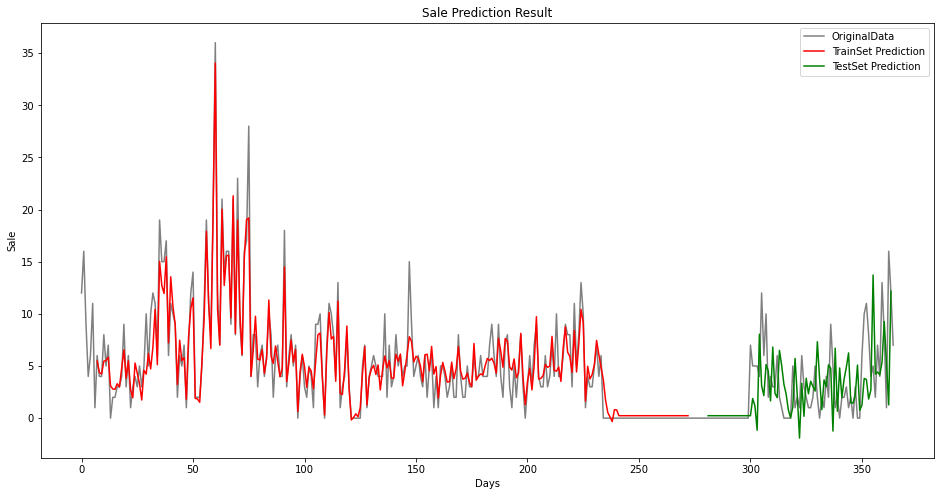

In [24]:
plt.figure(figsize=(16,8))

trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

plt.title('Sale Prediction Result')
plt.xlabel('Days')
plt.ylabel('Sale')

plt.plot(df, color='grey', label='OriginalData')
plt.plot(trainPredictPlot, color='red', label='TrainSet Prediction')
plt.plot(testPredictPlot, color='green', label='TestSet Prediction')

plt.legend()
plt.show()

In [26]:
scores = model.evaluate(trainX, trainY)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

266/266 [==============================] - 0s 45us/sample - loss: 2.6425 - accuracy: 0.1805
accuracy: 18.05%
